## Prerequisite

In [1]:
!uv pip install seaborn numpy matplotlib scikit-learn scipy
!uv pip install jax==0.4.26 jaxlib==0.4.26
!uv pip install flax optax
!uv pip install jax-metal
!uv pip install tqdm

Resolved 19 packages in 116ms                                                
Installed 16 packages in 146ms1                                     
 + contourpy==1.2.1
 + cycler==0.12.1
 + fonttools==4.53.0
 + joblib==1.4.2
 + kiwisolver==1.4.5
 + matplotlib==3.9.0
 + numpy==2.0.0
 + pandas==2.2.2
 + pillow==10.3.0
 + pyparsing==3.1.2
 + pytz==2024.1
 + scikit-learn==1.5.0
 + scipy==1.14.0
 + seaborn==0.13.2
 + threadpoolctl==3.5.0
 + tzdata==2024.1
Resolved 6 packages in 4ms                                                   
Installed 4 packages in 9ms3.3.0                                    
 + jax==0.4.26
 + jaxlib==0.4.26
 + ml-dtypes==0.4.0
 + opt-einsum==3.3.0
Resolved 26 packages in 389ms                                                
Installed 16 packages in 22ms8                                      
 + absl-py==2.1.0
 + chex==0.1.86
 + etils==1.9.2
 + flax==0.8.4
 + fsspec==2024.6.0
 + importlib-resources==6.4.0
 + markdown-it-py==3.0.0
 + mdurl==0.1.2
 + msgpack==1.0.8
 + op

In [15]:
from sklearn.datasets import make_swiss_roll
from typing import Sequence
import matplotlib.pyplot as plt

import jax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax
from functools import partial


## Loading Toy Dataset

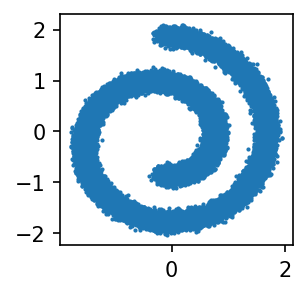

In [3]:
x, _ = make_swiss_roll(n_samples=100000, noise=0.5)
x = x[:, [0, 2]]

x = (x - x.mean()) / x.std()

plt.figure(figsize=(2, 2), dpi=150)
plt.scatter(x[:, 0], x[:, 1], s=1)

### MLP

In [4]:
class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.tanh(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    x = jnp.square(x)
    return x

### Fitting the Energy Function on this toy distribution

In [22]:
@jax.jit
def energy(state, params, x):
    return state.apply_fn({'params': params}, x).squeeze()

@jax.jit
def grad_energy_wrt_x(state, params, x):
    return jax.vmap(jax.grad(energy, argnums=2), in_axes=(None, None, 0))(state, params, x)

@jax.jit
def sample_langevin_dynamics(key, state, params, x, num_steps=3, step_size=0.01):
    def step(i, x):
        noise = jax.random.normal(jax.random.fold_in(key, i), shape=x.shape)
        grad = grad_energy_wrt_x(state, params, x)
        x = x - (step_size / 2.) * grad + jnp.sqrt(step_size) * noise
        return x
    
    return jax.lax.fori_loop(0, num_steps, step, x)

@partial(jax.jit, static_argnums=(4, 5))
def sample_langevin_dynamics_with_trajectory(key, state, params, x, num_steps, step_size):
    def step(carry, _):
        i, x, subkey = carry
        noise = jax.random.normal(subkey, shape=x.shape)
        grad = grad_energy_wrt_x(state, params, x)
        x = x - (step_size / 2.) * grad + jnp.sqrt(step_size) * noise
        return (i + 1, x, jax.random.fold_in(subkey, i)), x
    
    _, trajectory = jax.lax.scan(step, (0, x, key), None, length=num_steps)
    return trajectory

### Train the model using Langevin MCMC and Contrastive Divergence

In [6]:
@jax.jit
def train_mcmc_with_langevin(state, batch, key):
    key, subkey = jax.random.split(key)
    # prior = jax.random.normal(subkey, (256, 2))
    model_samples = sample_langevin_dynamics(subkey, state, state.params, batch)
    model_samples = jax.lax.stop_gradient(model_samples)

    def loss_fn(params):
        concat_samples = jnp.concatenate([batch, model_samples], axis=0)
        energies = energy(state, params, concat_samples)
        data_energy, model_energy = jnp.split(energies, 2)

        regularisation = 0.1 * (data_energy ** 2 + model_energy ** 2).mean()

        return data_energy.mean() - model_energy.mean() + regularisation

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

In [7]:
x = make_swiss_roll(n_samples=100000, noise=0.5)[0]
x = x[:, [0, 2]]

x = (x - x.mean()) / x.std()

In [8]:
model = MLP(features=[2, 128, 128, 1])
variables = model.init(jax.random.PRNGKey(0), x[0])

tx = optax.chain(
    optax.clip_by_global_norm(2.0),
    optax.adamw(learning_rate=1e-3)
)
key = jax.random.PRNGKey(0)
state = train_state.TrainState.create(apply_fn=model.apply, params=variables["params"], tx=tx)

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1719325141.840482 14916688 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1719325141.854999 14916688 service.cc:145] XLA service 0x124760790 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719325141.855024 14916688 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1719325141.856681 14916688 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1719325141.856705 14916688 mps_client.cc:384] XLA backend will use up to 22906109952 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [9]:
# Training loop
num_epochs = 500
batch_size = 128

for epoch in range(num_epochs):
    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, x.shape[0])
    permed_x = x[perm]
    
    for i in range(0, x.shape[0], batch_size):
        batch = jnp.array(permed_x[i:i + batch_size])
        key, subkey = jax.random.split(key)
        state, loss = train_mcmc_with_langevin(state, batch, subkey)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss}")

print("Training complete.")

Epoch 5, Loss: -0.007855340838432312
Epoch 10, Loss: -0.3052970767021179
Epoch 15, Loss: -0.1742085963487625
Epoch 20, Loss: 0.018006503582000732


KeyboardInterrupt: 

### Sampled Datapoints Visualisation

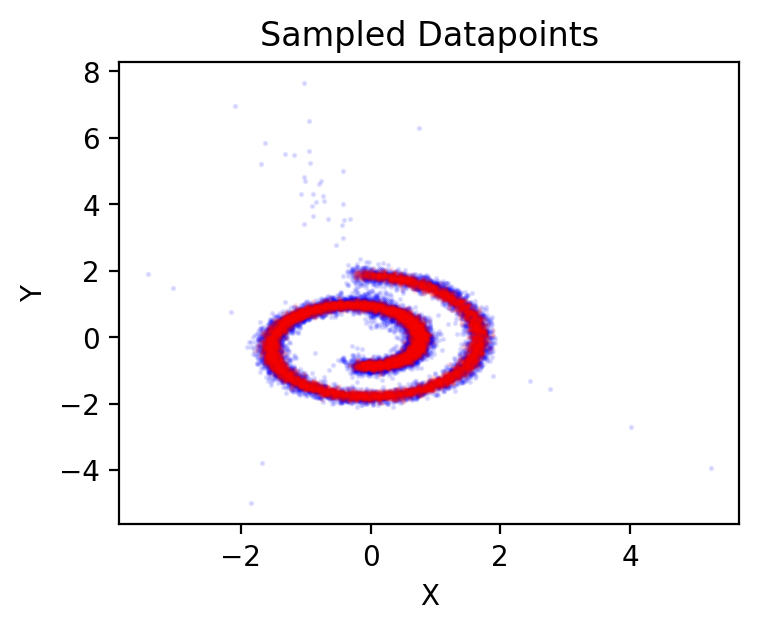

In [10]:
prior = jax.random.normal(key, (10000, 2))
model_samples = sample_langevin_dynamics(key, state, state.params, prior, num_steps=200, step_size=0.01)

plt.figure(figsize=(4, 3), dpi=200)
plt.scatter(model_samples[:, 0], model_samples[:, 1], s=1, color='blue', alpha=0.1)
plt.scatter(x[:10000, 0], x[:10000, 1], s=1, color='red', alpha=0.08)
plt.title('Sampled Datapoints')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

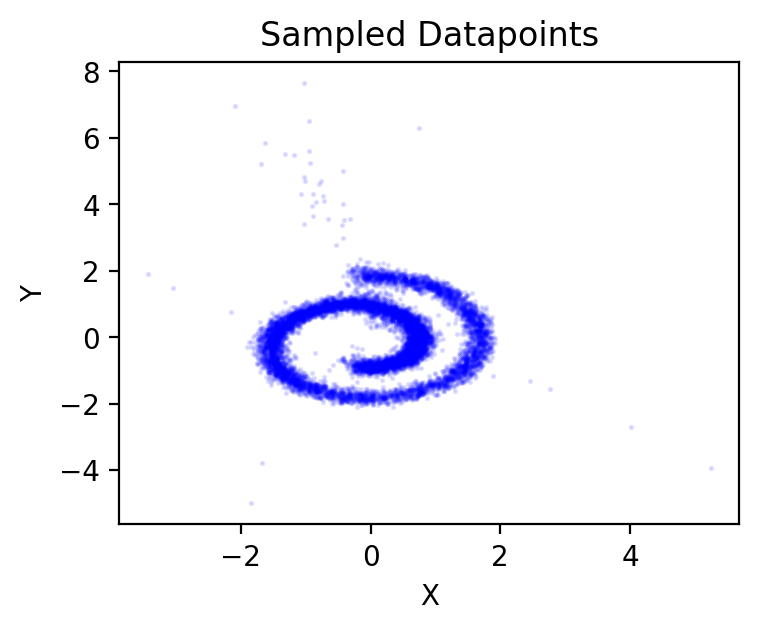

In [11]:
plt.figure(figsize=(4, 3), dpi=200)
plt.scatter(model_samples[:, 0], model_samples[:, 1], s=1, color='blue', alpha=0.1)
# plt.scatter(x[:10000, 0], x[:10000, 1], s=1, color='red', alpha=0.08)
plt.title('Sampled Datapoints')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Trajectories Visualisation

In [116]:
def visualize_langevin_trajectories(state, params, trajectories):
    # Plotting
    fig, ax = plt.subplots(figsize=(8, 8), dpi=150)
    
    colors = plt.cm.rainbow(np.linspace(0, 1, trajectories.shape[1]))
    
    for i in range(trajectories.shape[1]):
        trajectory = trajectories[:, i, :]
        ax.plot(trajectory[:, 0], trajectory[:, 1], c=colors[i], alpha=0.5, linewidth=1)
        ax.scatter(trajectory[0, 0], trajectory[0, 1], c=[colors[i]], s=50, marker='o', label=f'Start {i+1}')
        ax.scatter(trajectory[-1, 0], trajectory[-1, 1], c=[colors[i]], s=50, marker='s', label=f'End {i+1}')
    
    ax.set_title('Langevin Dynamics Trajectories')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.get_legend().remove()
    plt.tight_layout()
    plt.show()

    # Plot energy landscape
    x_range = np.linspace(-3, 3, 100)
    y_range = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x_range, y_range)
    XY = jnp.array(np.column_stack([X.ravel(), Y.ravel()]))
    
    # print(XY.shape)
    energies = state.apply_fn({'params': params}, XY).reshape(X.shape)
    # energies = np.array(jax.vmap(lambda x: energy(params, x))(XY)).reshape(X.shape)
    
    fig, ax = plt.subplots(figsize=(10, 8), dpi=150)
    contour = ax.contourf(X, Y, energies, levels=50, cmap='viridis')
    fig.colorbar(contour, ax=ax, label='Energy')
    
    for i in range(trajectories.shape[1]):
        trajectory = trajectories[:, i, :]
        ax.plot(trajectory[:, 0], trajectory[:, 1], c=colors[i], alpha=0.8, linewidth=2)
        ax.scatter(trajectory[0, 0], trajectory[0, 1], c=[colors[i]], s=50, marker='o', label=f'Start {i+1}')
        ax.scatter(trajectory[-1, 0], trajectory[-1, 1], c=[colors[i]], s=50, marker='s', label=f'End {i+1}')
    
    ax.set_title('Langevin Dynamics Trajectories on Energy Landscape')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.get_legend().remove()
    plt.tight_layout()
    plt.show()

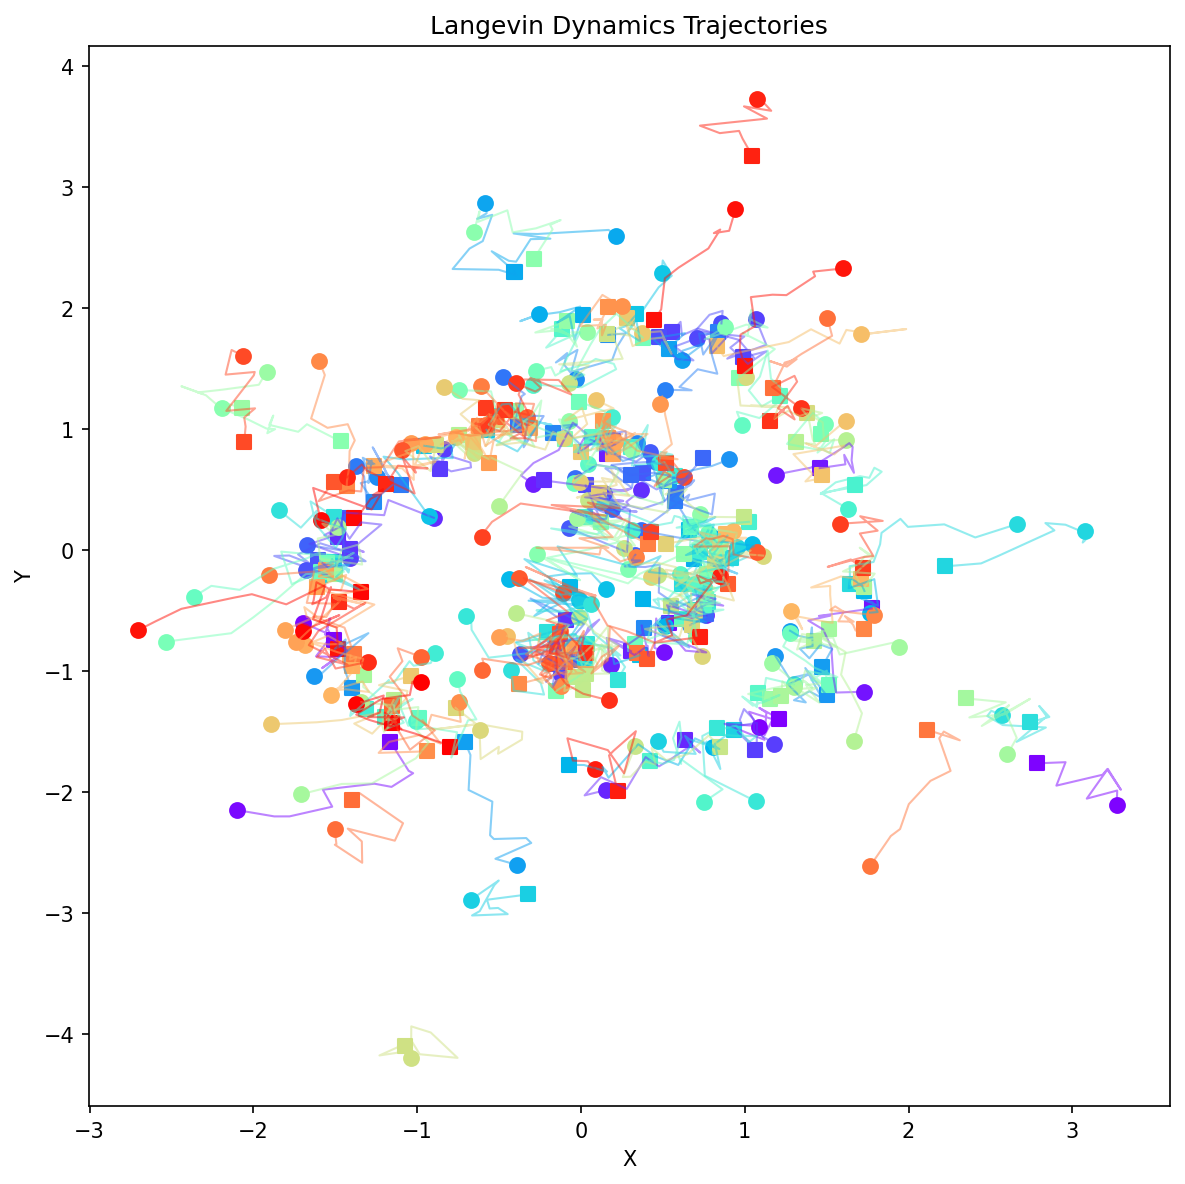

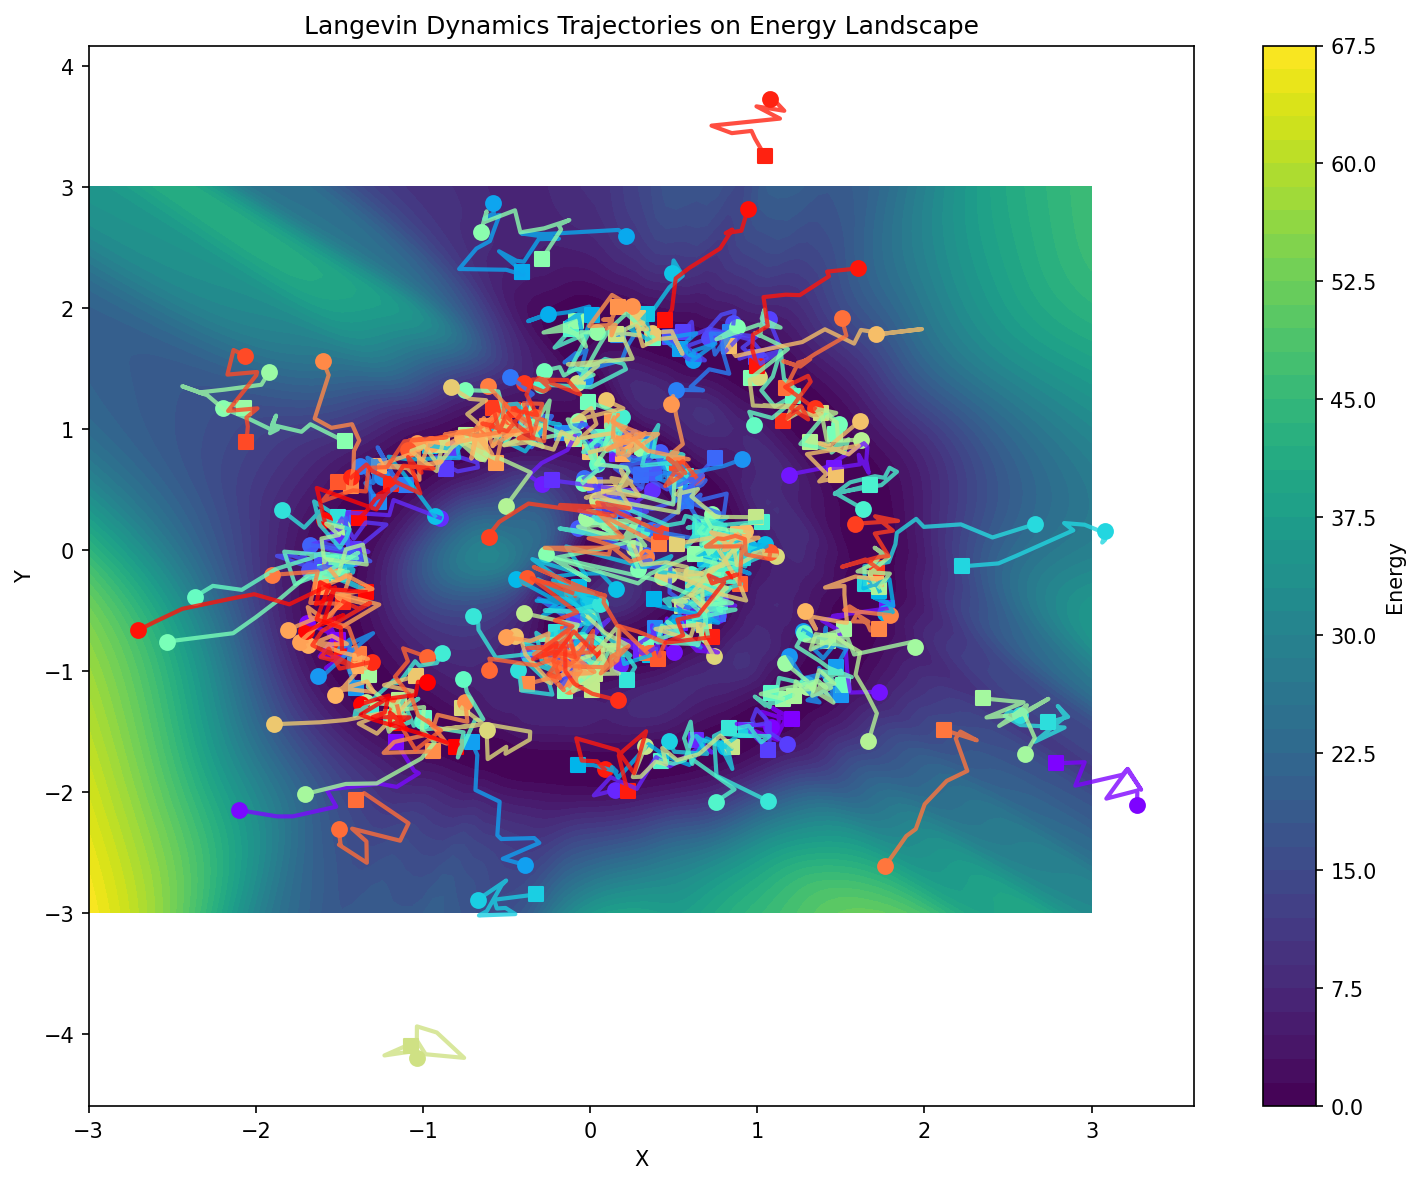

In [120]:
priors = jax.random.normal(key, (200, 2))
trajectories = sample_langevin_dynamics_with_trajectory(key, state, state.params, priors, num_steps=10, step_size=0.01)

visualize_langevin_trajectories(state, state.params, trajectories)

### Pre-conditioned Langevin Dynamics

In [117]:
@partial(jax.jit, static_argnums=(5, 6), backend='cpu')
def sample_pre_conditioned_langevin_dynamics_with_trajectory(key, state, params, x, preconditioner, num_steps, step_size):
    def step(carry, _):
        i, x, subkey = carry
        noise = jax.random.normal(subkey, shape=x.shape)
        grad = grad_energy_wrt_x(state, params, x)
        precond_sqrt = jax.scipy.linalg.sqrtm(preconditioner)
        precond_sqrt = jnp.real(precond_sqrt)
        
        x = x - (step_size / 2.) * jnp.einsum('ij,kj->ki', preconditioner, grad) + jnp.sqrt(step_size) * jnp.einsum('ij,kj->ki', precond_sqrt, noise)
        return (i + 1, x, jax.random.fold_in(subkey, i)), x
    
    _, trajectory = jax.lax.scan(step, (0, x, key), None, length=num_steps)
    return trajectory

In [156]:
num_samples = 20
num_samples_preconditioned = 10
conditioner_prior = jax.random.normal(key, (num_samples_preconditioned, 2))
random_samples = sample_langevin_dynamics(key, state, state.params, conditioner_prior, num_steps=200, step_size=0.01)
preconditioner = jnp.cov(random_samples, rowvar=False)

In [151]:
sample_prior = jax.random.normal(key, (num_samples, 2))

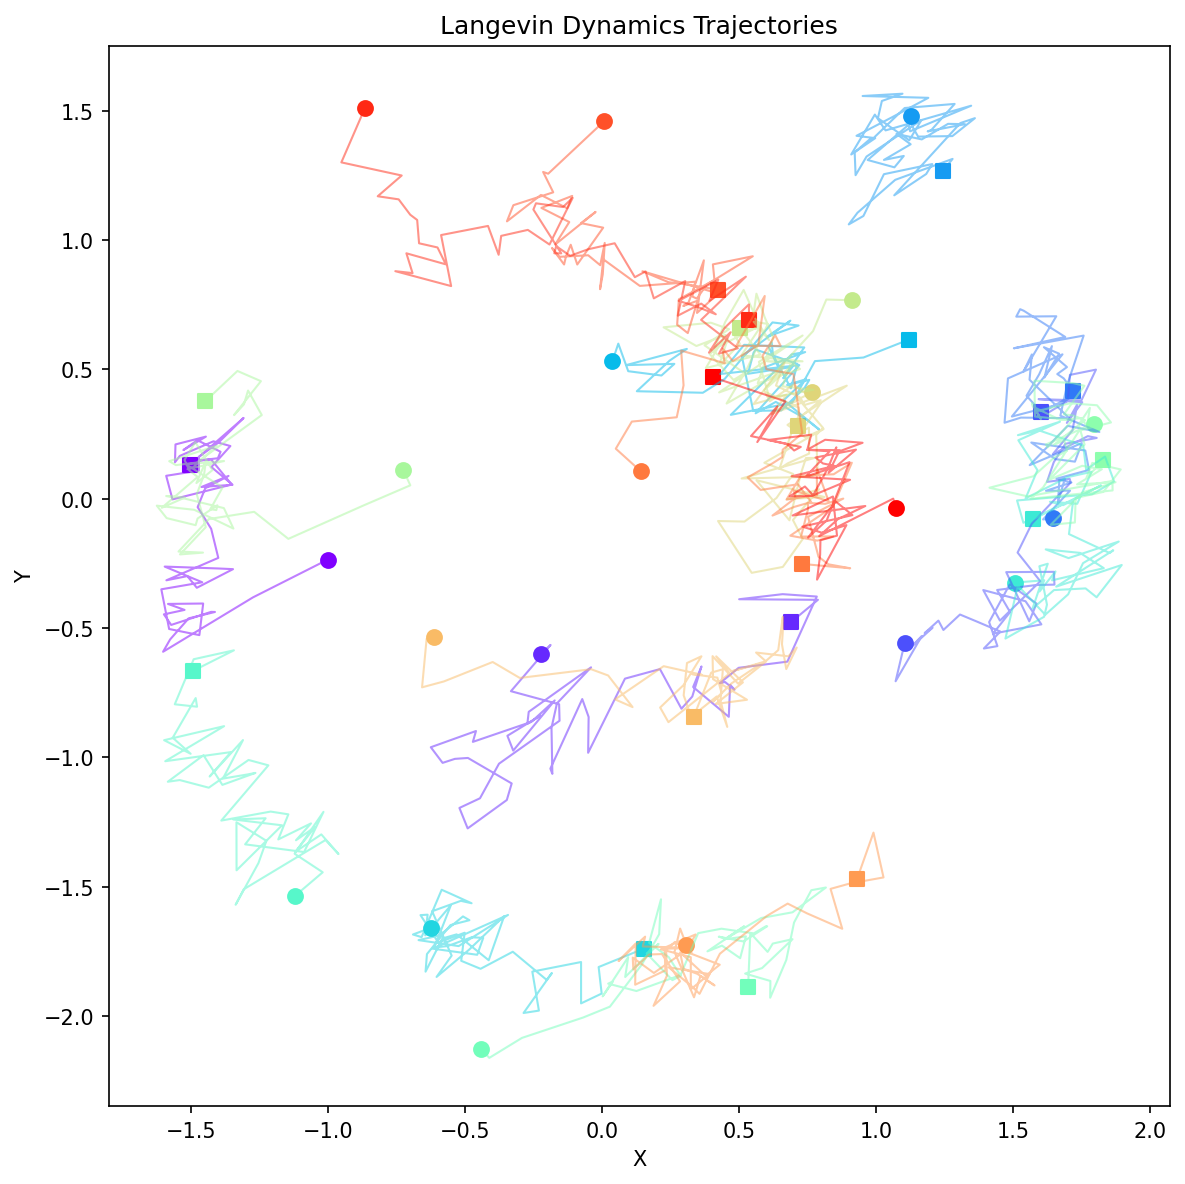

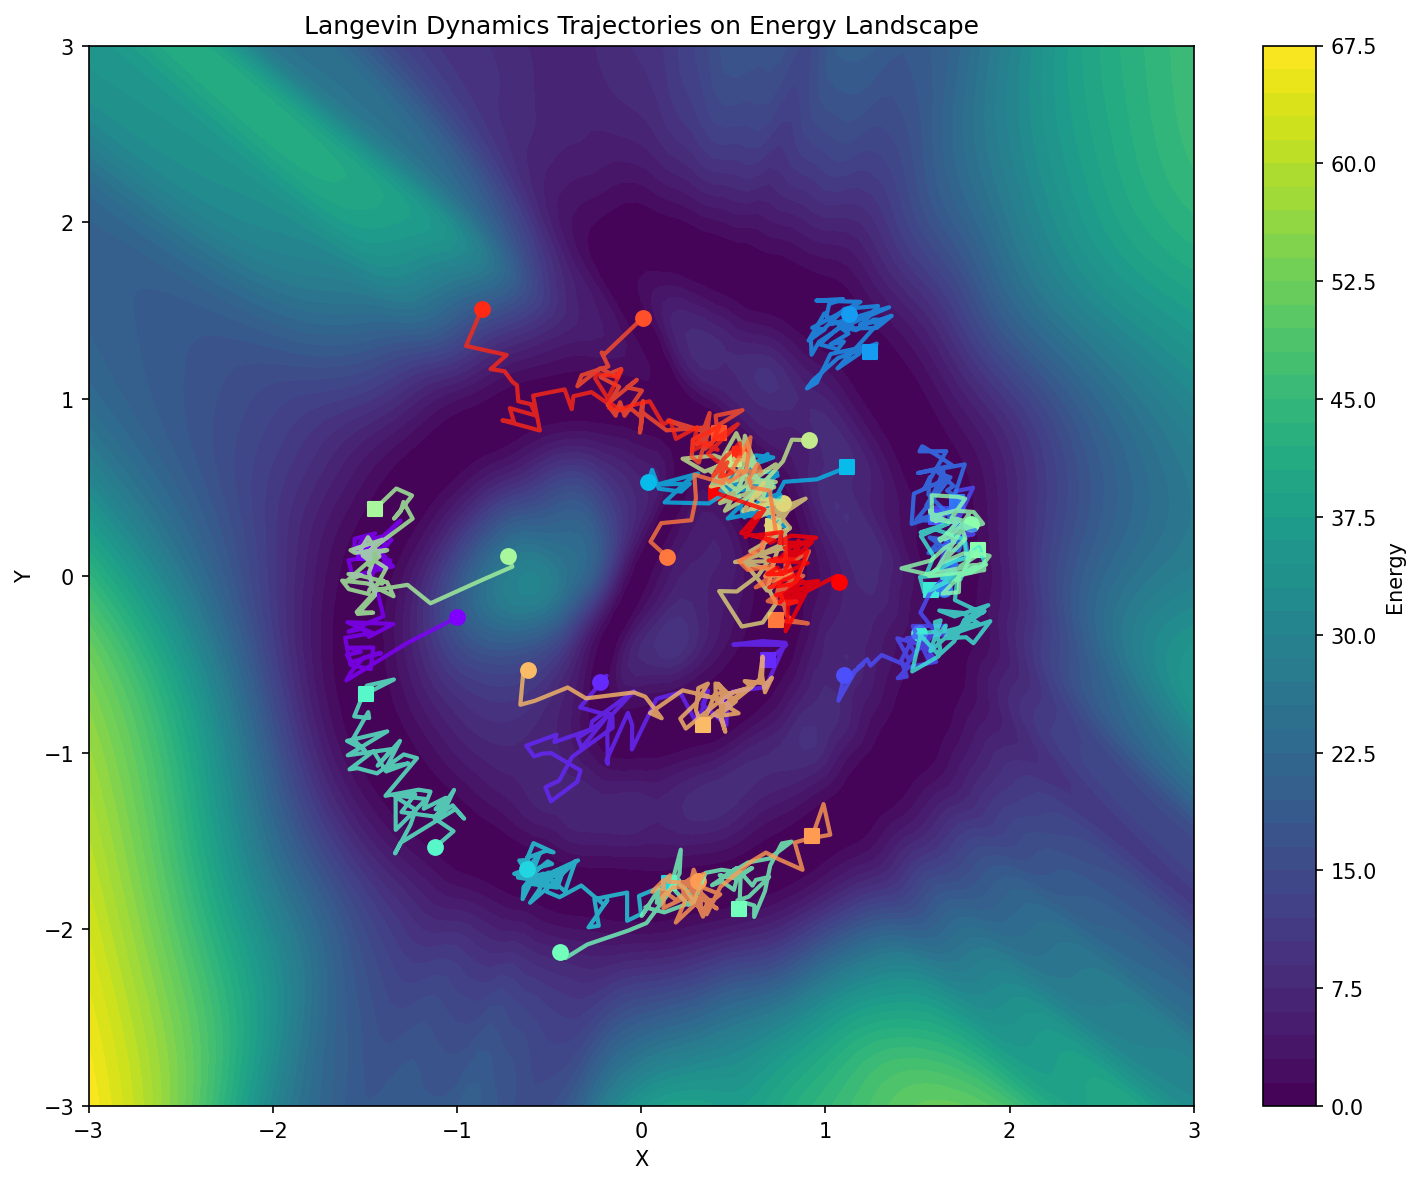

In [157]:
trajectories = sample_pre_conditioned_langevin_dynamics_with_trajectory(key, state, state.params, prior, preconditioner, num_steps=50, step_size=0.01)
visualize_langevin_trajectories(state, state.params, trajectories)